# WASP-4 analysis
Author: Néstor Espinoza (nespinoza@stsci.edu)

Let's start by importing relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import juliet

Let's download WASP-4 lightcurves:

In [2]:
t,f,ferr = juliet.get_all_TESS_data('WASP-4b')

Which sector is this data from?

In [3]:
t.keys()

dict_keys(['TESS2'])

Sector 2. Now let's see how this data looks like:

(0.11435756925493479, 27.518166539724916)

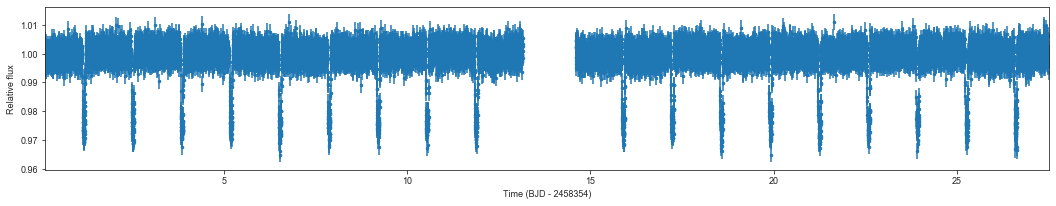

In [4]:
tstart = t['TESS2'][0]
tend = t['TESS2'][-1]
plt.figure(figsize=(18,3))
plt.errorbar(t['TESS2']-int(tstart), f['TESS2'],ferr['TESS2'],fmt='.')
plt.xlabel(f'Time (BJD - {int(tstart)})')
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])

## Fitting it like in the paper

In the paper this is fit using a more or less strict period and time-of-transit center prior based on [Huitson et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154...95H/abstract). Let's see if we obtain the same results as in the paper here:

In [5]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS2','q2_TESS2','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_TESS2', 'mflux_TESS2', 'sigma_w_TESS2', 'GP_sigma_TESS2', 'GP_rho_TESS2', \
         'GP_timescale_TESS2']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[1.33823204,0.000023], [2458355.185,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [1,100.], 1.0, [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [6]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, out_folder = 'WASP-4b-ExpMatern')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 1000)

  analysing data from WASP-4b-ExpMatern/jomnest_.txt


Let's see how the fit looks like:

(0.11435756925493479, 27.518166539724916)

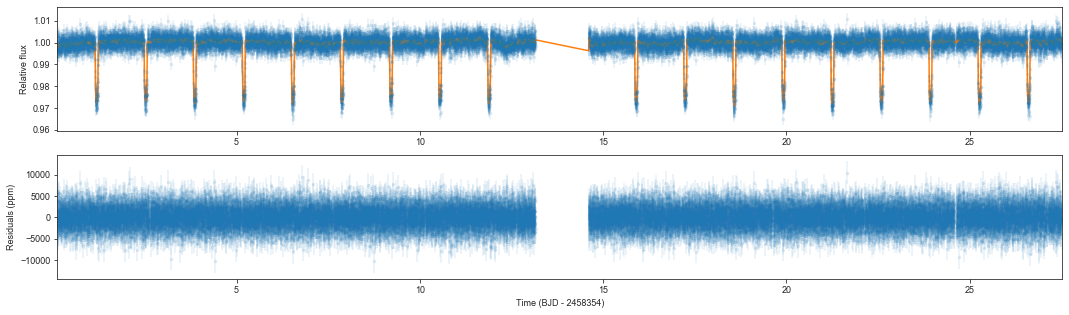

In [7]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
plt.errorbar(dataset.times_lc['TESS2']-int(tstart), dataset.data_lc['TESS2'], \
             yerr = dataset.errors_lc['TESS2'], fmt = '.', alpha = 0.1)

# Plot the model:
model = results.lc.evaluate('TESS2')
plt.plot(dataset.times_lc['TESS2']-int(tstart), model)

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
plt.errorbar(dataset.times_lc['TESS2']-int(tstart), (dataset.data_lc['TESS2'] - model)*1e6, \
         yerr = dataset.errors_lc['TESS2']*1e6, fmt = '.', alpha = 0.1)
plt.ylabel('Residuals (ppm)')
plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])

That looks good. What about the phased lightcurve?

dict_keys(['ones', 'M', 'LM', 'deterministic', 'deterministic_errors', 'params', 'm', 'p1', 'deterministic_variances', 'GP'])


(-2500, 2500)

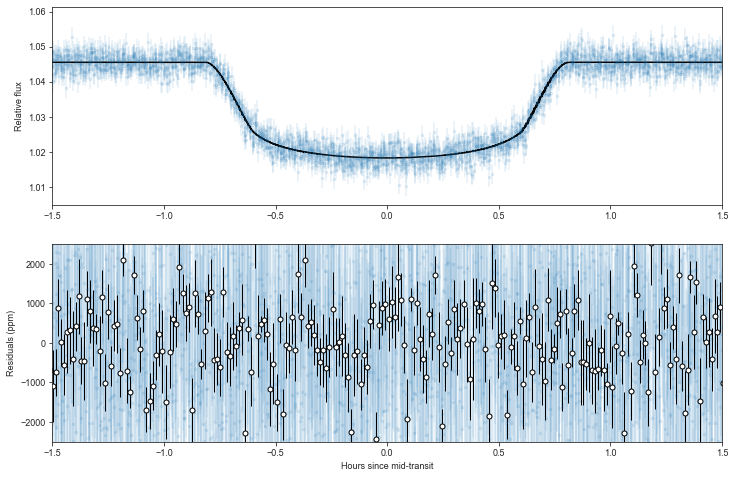

In [8]:
# Get phases:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \
        np.median(results.posteriors['posterior_samples']['t0_p1'])

phases = juliet.utils.get_phases(dataset.times_lc['TESS2'], P, t0)

# Plot:
plt.figure(figsize=(12,8))

plt.subplot(211)
# Extract model components:
transit_model = results.lc.model['TESS2']['deterministic']
gp_component = results.lc.model['TESS2']['GP']
print(results.lc.model['TESS2'].keys())

# Plot the data:
plt.errorbar(phases*24, dataset.data_lc['TESS2'] - gp_component, \
             yerr = dataset.errors_lc['TESS2'], fmt = '.', alpha = 0.1)

# Plot the model:
idx = np.argsort(phases)
plt.plot(phases[idx]*24, transit_model[idx] ,color='black')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([-1.5,1.5])
# Plot residuals:
plt.subplot(212)
plt.errorbar(phases*24, (dataset.data_lc['TESS2'] - model)*1e6, \
             yerr = (dataset.errors_lc['TESS2'])*1e6, fmt = '.', alpha = 0.1)

pbin,ybin,ybinerr = juliet.utils.bin_data(phases[idx]*24, (dataset.data_lc['TESS2'][idx] - model[idx])*1e6, 10)
plt.errorbar(pbin,ybin,yerr=ybinerr,fmt='o',mfc='white',mec='black',ecolor='black',elinewidth=1)
plt.xlabel('Hours since mid-transit')
plt.ylabel('Residuals (ppm)')
plt.xlim([-1.5,1.5])
plt.ylim([-2500,2500])

All right, that looks nice. Now let's check the timing --- what time-of-transit do we get?

In [9]:
print(np.median(results.posteriors['posterior_samples']['t0_p1']),np.sqrt(np.var(results.posteriors['posterior_samples']['t0_p1'])))

2458355.18451163 0.00019047613457918208


How does it compare to those of Bouma et al. (2019)?

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   3.,   2.,   3.,   2.,   3.,   4.,   5.,   5.,
         11.,   8.,  13.,  11.,  20.,  28.,  28.,  40.,  43.,  50.,  54.,
         65.,  74., 104.,  87., 110., 126., 147., 146., 154., 144., 195.,
        192., 228., 236., 235., 244., 258., 255., 259., 275., 259., 260.,
        262., 253., 244., 255., 218., 204., 214., 192., 194., 152., 136.,
        123., 142., 106., 124., 102.,  84.,  57.,  60.,  52.,  43.,  47.,
         28.,  23.,  24.,  17.,  16.,  14.,   8.,   6.,   4.,   4.,   2.,
          1.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-156.70210719, -154.39390607, -152.08570495, -149.77750383,
        -147.46930271, -145.16110159, -142.85290048, -140.54469936,
        -138.23649824, -135.92829712, -133.620096  , -131.31189488,
        -129.00369376, -126.69549264, -124.38729152, -122.0790904 ,
        -119.77088928, -117.46268816, -115.154

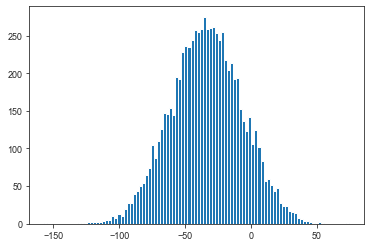

In [10]:
t0_bouma = np.random.normal(2458355.18490,0.00025,len(results.posteriors['posterior_samples']['t0_p1']))
plt.hist((results.posteriors['posterior_samples']['t0_p1']-t0_bouma)*24*3600,bins=100)

They are consistent. Our values appear to have slightly larger uncertainties however! And that considering we only took one transit from Bouma et al. 

What about the limb-darkening coefficients?

u1 = 0.348 +/- 0.105 u2 = 0.294 +/- 0.219


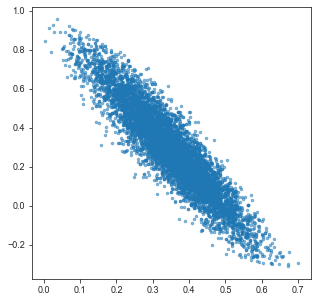

In [11]:
fig = plt.figure(figsize=(5,5))
# Store posterior samples for q1 and q2:
q1, q2 = results.posteriors['posterior_samples']['q1_TESS2'],\
          results.posteriors['posterior_samples']['q2_TESS2']

# Transform back to (u1,u2):
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot posterior distribution:
plt.plot(u1,u2,'.',alpha=0.5)
u1_m,u1_err = np.median(u1), np.sqrt(np.var(u1))
u2_m,u2_err = np.median(u2), np.sqrt(np.var(u2))


print('u1 = {0:.3f} +/- {1:.3f}'.format(u1_m,u1_err), 'u2 = {0:.3f} +/- {1:.3f}'.format(u2_m,u2_err))

Relatively large errobars --- but interestingly, the value does not match the ones in the paper. Let's try the same fit, but with the QP Kernel:

In [12]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS2','q2_TESS2','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_TESS2', 'mflux_TESS2', 'sigma_w_TESS2', 'GP_B_TESS2', 'GP_C_TESS2', \
         'GP_L_TESS2','GP_Prot_TESS2']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform', \
        'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[1.33823204,0.000023], [2458355.185,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [1,100.], 1.0, [0.,0.1], [0.1, 10000.], [1e-5, 1000.], [1e-5, 1000.], [1e-5, 1000.],\
           [0.1,30]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [13]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, out_folder = 'WASP-4b-QP')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 1000)

(0.11435756925493479, 27.518166539724916)

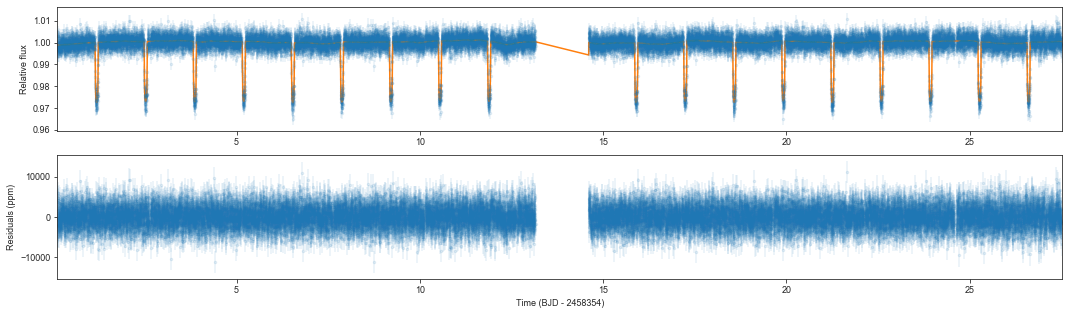

In [14]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
plt.errorbar(dataset.times_lc['TESS2']-int(tstart), dataset.data_lc['TESS2'], \
             yerr = dataset.errors_lc['TESS2'], fmt = '.', alpha = 0.1)

# Plot the model:
model = results.lc.evaluate('TESS2')
plt.plot(dataset.times_lc['TESS2']-int(tstart), model)

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
plt.errorbar(dataset.times_lc['TESS2']-int(tstart), (dataset.data_lc['TESS2'] - model)*1e6, \
         yerr = dataset.errors_lc['TESS2']*1e6, fmt = '.', alpha = 0.1)
plt.ylabel('Residuals (ppm)')
plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])

dict_keys(['ones', 'M', 'LM', 'deterministic', 'deterministic_errors', 'params', 'm', 'p1', 'deterministic_variances', 'GP'])


(-2500, 2500)

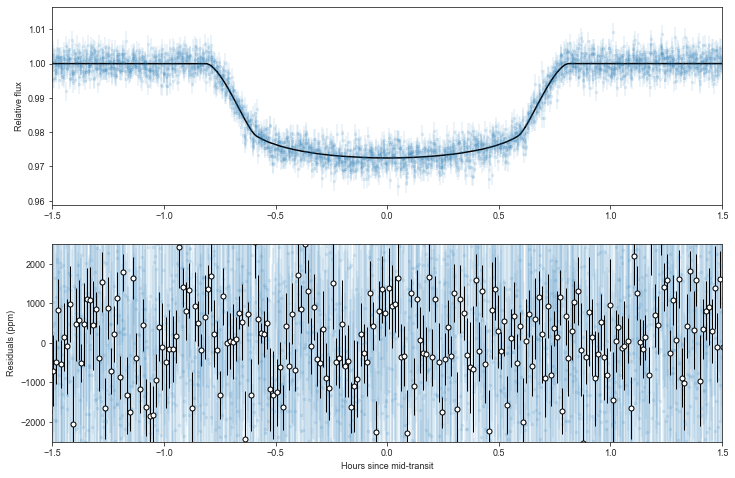

In [15]:
# Get phases:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \
        np.median(results.posteriors['posterior_samples']['t0_p1'])

phases = juliet.utils.get_phases(dataset.times_lc['TESS2'], P, t0)

# Plot:
plt.figure(figsize=(12,8))

plt.subplot(211)
# Extract model components:
transit_model = results.lc.model['TESS2']['deterministic']
gp_component = results.lc.model['TESS2']['GP']
print(results.lc.model['TESS2'].keys())

# Plot the data:
plt.errorbar(phases*24, dataset.data_lc['TESS2'] - gp_component, \
             yerr = dataset.errors_lc['TESS2'], fmt = '.', alpha = 0.1)

# Plot the model:
idx = np.argsort(phases)
plt.plot(phases[idx]*24, transit_model[idx] ,color='black')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([-1.5,1.5])
# Plot residuals:
plt.subplot(212)
plt.errorbar(phases*24, (dataset.data_lc['TESS2'] - model)*1e6, \
             yerr = (dataset.errors_lc['TESS2'])*1e6, fmt = '.', alpha = 0.1)

pbin,ybin,ybinerr = juliet.utils.bin_data(phases[idx]*24, (dataset.data_lc['TESS2'][idx] - model[idx])*1e6, 10)
plt.errorbar(pbin,ybin,yerr=ybinerr,fmt='o',mfc='white',mec='black',ecolor='black',elinewidth=1)
plt.xlabel('Hours since mid-transit')
plt.ylabel('Residuals (ppm)')
plt.xlim([-1.5,1.5])
plt.ylim([-2500,2500])

Basically the same result. Time of transit?

2458355.184470873 0.00010757654500424806


(array([  2.,   1.,   0.,   0.,   1.,   1.,   4.,   1.,   3.,   4.,   1.,
          2.,   3.,   4.,   3.,   4.,  12.,   9.,   8.,  19.,  18.,  25.,
         24.,  22.,  39.,  33.,  34.,  46.,  66.,  78.,  72.,  81.,  94.,
        106., 102., 135., 119., 133., 142., 143., 158., 166., 184., 203.,
        211., 216., 232., 248., 238., 230., 228., 223., 228., 221., 245.,
        237., 247., 231., 217., 180., 234., 172., 181., 174., 168., 128.,
        161., 150., 115., 131., 110.,  97.,  99.,  76.,  72.,  60.,  52.,
         49.,  44.,  32.,  39.,  37.,  19.,  23.,  18.,  22.,  10.,  12.,
         10.,  10.,   6.,   6.,   3.,   3.,   4.,   0.,   2.,   1.,   0.,
          2.]),
 array([-125.53699762, -123.85364042, -122.17028323, -120.48692603,
        -118.80356884, -117.12021165, -115.43685445, -113.75349726,
        -112.07014006, -110.38678287, -108.70342568, -107.02006848,
        -105.33671129, -103.65335409, -101.9699969 , -100.28663971,
         -98.60328251,  -96.91992532,  -95.236

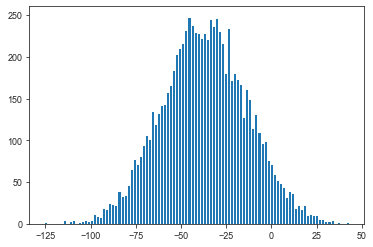

In [16]:
print(np.median(results.posteriors['posterior_samples']['t0_p1']),np.sqrt(np.var(results.posteriors['posterior_samples']['t0_p1'])))

t0_bouma = np.random.normal(2458355.18490,0.00025,len(results.posteriors['posterior_samples']['t0_p1']))
plt.hist((results.posteriors['posterior_samples']['t0_p1']-t0_bouma)*24*3600,bins=100)

Still consistent with Bouma, much smaller uncertainty than wit. Much better uncertainties in this case. What about the LDCs?

u1 = 0.394 +/- 0.060 u2 = 0.181 +/- 0.134


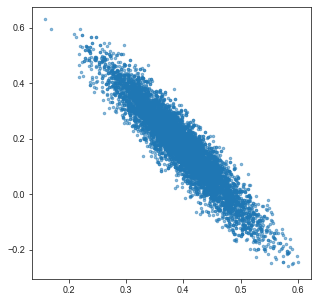

In [17]:
fig = plt.figure(figsize=(5,5))
# Store posterior samples for q1 and q2:
q1, q2 = results.posteriors['posterior_samples']['q1_TESS2'],\
          results.posteriors['posterior_samples']['q2_TESS2']

# Transform back to (u1,u2):
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot posterior distribution:
plt.plot(u1,u2,'.',alpha=0.5)
u1_m,u1_err = np.median(u1), np.sqrt(np.var(u1))
u2_m,u2_err = np.median(u2), np.sqrt(np.var(u2))


print('u1 = {0:.3f} +/- {1:.3f}'.format(u1_m,u1_err), 'u2 = {0:.3f} +/- {1:.3f}'.format(u2_m,u2_err))

Interestingly, different from the ones in the paper. LDCs are actually consistent with the theoretical values!